## Load Dataset

### Source Dataset

In [25]:
# Load directories
train_data_dir = "../input/kittiroadsegmentation/training/image_2/"
train_gt_dir = "../input/kittiroadsegmentation/training/gt_image_2/"

test_data_dir = "../input/kittiroadsegmentation/testing/"

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [26]:
# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


## Why the Input Size is Set to 128

Segmentation models require a consistent input size and dimensions that can be repeatedly divided by 2 during the encoder’s pooling operations.  
In architectures such as VGG16, the image is downsampled five times using `MaxPooling2D` with a stride of 2. Each pooling layer divides the spatial dimensions in half:

- 128 → 64  
- 64 → 32  
- 32 → 16  
- 16 → 8  
- 8 → 4  

These values remain integers at every stage, which is necessary for the decoder to reconstruct the segmentation mask correctly during upsampling.

Non-power-of-two dimensions (e.g., 100) result in fractional sizes during the downsampling path: 100 → 50 → 25 → 12.5 → 6.25 → 3.125

Fractional spatial sizes are invalid for convolutional layers and break the encoder–decoder symmetry.  
Choosing 128 ensures clean downsampling and stable model behaviour.

---

## Why N_CLASSES Is Set to 1

Setting `N_CLASSES = 1` indicates that the task is a **binary segmentation problem**. The model predicts whether each pixel belongs to the foreground class or to the background.

Typical binary segmentation examples include:

- Road vs non-road  
- Tumor vs healthy tissue  
- Object vs background  

The model outputs a single-channel probability mask of shape `(128, 128, 1)` and uses a **sigmoid** activation function.

For multi-class segmentation (e.g., car, road, pedestrian), the model would require:

- `N_CLASSES` equal to the number of classes  
- A **softmax** activation instead of sigmoid  
- A multi-channel output mask  

---

## Purpose of Setting SEED = 123

The seed value is used to make the entire training pipeline reproducible.  
This affects:

- Random data shuffling  
- Dataset splits  
- Data augmentation randomness  
- Weight initialization in model layers  

Using the same seed ensures that separate training runs produce consistent and comparable results.

In [27]:
# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

In [9]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    
    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [10]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

#### Visualize multiple samples at once

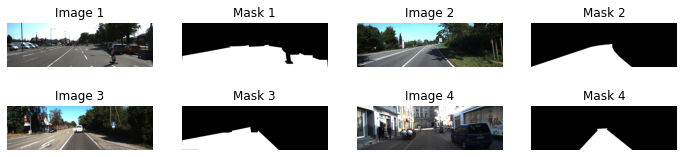

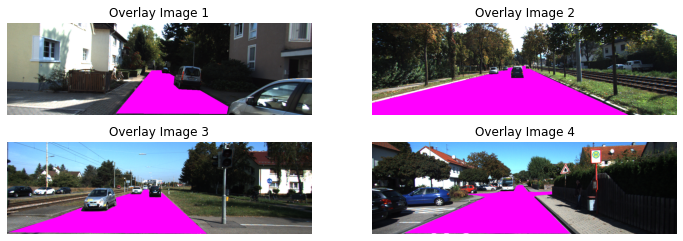

Image shape: (375, 1242, 3)
Mask shape: (375, 1242, 1)
Unique mask values: [0 1]


In [11]:
plt.figure(figsize=(12, 12))

for i, sample in enumerate(all_dataset.take(4)):
    image = sample['image'].numpy()
    mask = sample['segmentation_mask'].numpy()

    # Image
    plt.subplot(8, 4, 2*i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis("off")

    # Mask
    plt.subplot(8, 4, 2*i+2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.show()


## Overlay 
plt.figure(figsize=(12,4))

for i, sample in enumerate(all_dataset.take(4)):
    image = sample['image'].numpy()
    mask = sample['segmentation_mask'].numpy().squeeze()

    # Create overlay
    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 255]   # highlight road pixels in pink

    # Plot
    plt.subplot(2,2, i+1)       # 2 rows × 2 columns
    plt.imshow(overlay)
    plt.title(f"Overlay Image {i+1}")
    plt.axis("off")

plt.show()


## Shape

sample = next(iter(all_dataset))
print("Image shape:", sample['image'].shape)
print("Mask shape:", sample['segmentation_mask'].shape)
print("Unique mask values:", np.unique(sample['segmentation_mask']))

# Apply Transformations

## Image Normalization

The `normalize` function converts raw image pixels into a format suitable for neural networks.  
Segmentation models typically expect floating-point inputs scaled to the range **[0, 1]**.

- The input image is cast from `uint8` (0–255) to `float32`.  
- Pixel values are divided by 255.0 to obtain normalized values.  
- Only the image is normalized; the mask remains unchanged because it already contains class labels (0 or 1).

Normalization ensures numerical stability and supports smoother gradient updates.

---

## Training Preprocessing Pipeline

The `load_image_train` function prepares each `(image, mask)` pair for training:

### 1. Resizing
Both the image and its segmentation mask are resized to a consistent spatial shape of **128×128** pixels.  
A uniform size is required so the segmentation model receives fixed-shape tensors.

### 2. Random Horizontal Flip  
A horizontal flip is applied with a probability of 0.5 as part of data augmentation.  
The operation is applied simultaneously to both the image and the mask to preserve spatial consistency.  
This augmentation appears only in the training pipeline so that validation metrics reflect real performance.

### 3. Normalization  
The image is normalized to a `[0, 1]` range using the `normalize` function.  
The mask is returned unchanged.

The function returns a fully preprocessed pair ready for input to the model.

---

## Validation Preprocessing Pipeline

The `load_image_test` function processes validation and test samples.  
This pipeline is deterministic and does not include augmentation.

- Images and masks are resized to **128×128**.  
- Normalization is applied to the image only.  
- No flipping or random transformations are used.

Because validation is meant to measure model performance on unseen data, nondeterministic augmentations are intentionally excluded.

---

## Summary of the Data Pipeline

- **Training Pipeline**  
  - Resize  
  - Optional horizontal flip  
  - Normalize image  
  - Return `(image, mask)`

- **Validation Pipeline**  
  - Resize  
  - Normalize image  
  - Return `(image, mask)`

These preprocessing functions ensure both consistency of input dimensions and appropriate data variability during training, while maintaining deterministic evaluation during validation.

In [12]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

## Dataset Pipeline Overview

The dataset pipeline is organized into three components: **training**, **validation**, and **testing**.  
Each component uses the `tf.data` API to ensure efficient loading, preprocessing, and batching of images and masks for the segmentation model.

---

## Batch Size and Buffer Size

### `BATCH_SIZE = 32`
Models do not process single images at a time.  
Instead, training is performed in mini-batches to improve computational efficiency and stabilize gradient updates.  
A batch size of 32 means that each training step processes 32 samples simultaneously.

### `BUFFER_SIZE = 1000`
The shuffle buffer determines how many samples are kept in memory for randomization.  
A large buffer (e.g., 1000) ensures strong shuffling and prevents the model from seeing data in the same order every epoch.

---

## Training Dataset Pipeline

The training pipeline includes operations that introduce randomness to improve generalization.

### 1. Mapping
Each sample passes through the `load_image_train` preprocessing function.  
Mapping is parallelized across CPU threads using `tf.data.AUTOTUNE`, which automatically determines the optimal number of threads.

### 2. Shuffling
The dataset is randomly shuffled using the defined buffer size to produce a new ordering of samples each epoch.

### 3. Repeating
The dataset is repeated indefinitely.  
Repeating allows `model.fit()` to consume an endless stream of data so that the number of training steps per epoch is controlled manually using `steps_per_epoch`.

### 4. Batching
Samples are grouped into mini-batches of 32 items.  
Each batch is fed to the model as one training step.

### 5. Prefetching
Prefetching loads batch *N+1* while the GPU is processing batch *N*.  
This removes input bottlenecks and increases overall training throughput.

---

## Validation Dataset Pipeline

The validation pipeline excludes any form of randomness to ensure consistent evaluation.

### Differences from training:
- **No shuffling**  
  Validation must be deterministic.
- **No augmentation**  
  Images are evaluated in their raw form.
- **Repeat()**  
  Validation data is repeated to ensure that it does not run out during evaluation.

### Operations performed:
- Map using `load_image_test`
- Repeat
- Batch
- Prefetch

This pipeline measures real model performance without artificially altering the data.

---

## Testing Dataset Pipeline

The testing pipeline is the simplest and is used only for final evaluation or prediction.

### Key differences:
- **No repeat()**  
  Test data is evaluated exactly once.
- **No shuffling and no augmentation**  
  Test results must be consistent and directly comparable.
- **Batch + prefetch** for efficiency

### Operations performed:
- Map using `load_image_test`
- Batch
- Prefetch

The test pipeline focuses exclusively on accuracy and inference speed.

---

## Summary

- **Training pipeline**: random, augmented, shuffled, repeated, batched, prefetched  
- **Validation pipeline**: deterministic, resized-only, repeated, batched, prefetched  
- **Testing pipeline**: deterministic, single-pass, resized-only, batched, prefetched  

These pipelines ensure:
- maximum GPU utilization during training  
- correct and reproducible evaluation during validation  
- reliable final inference during testing  

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


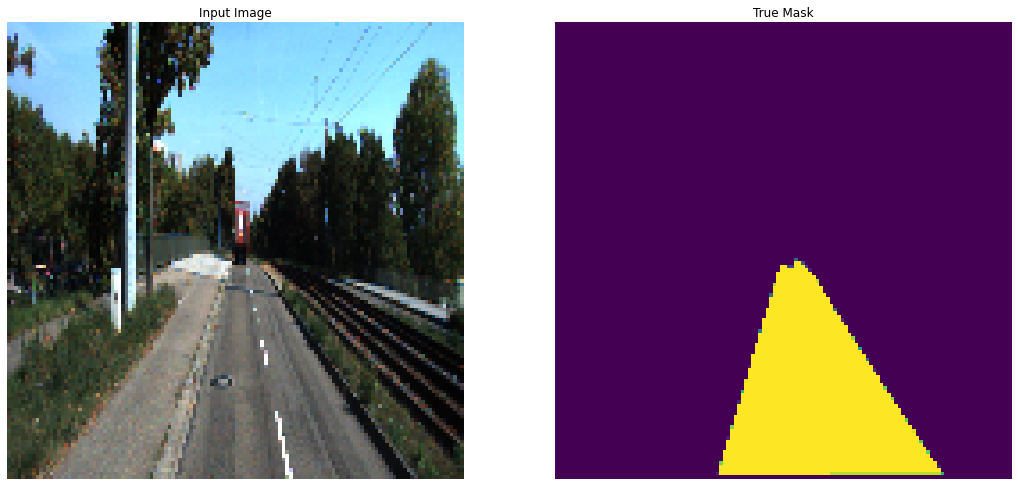

In [14]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

# VGG-16 Encoder Overview

VGG-16 is composed of five sequential convolutional blocks, each followed by max-pooling.  
Pooling progressively reduces spatial resolution while increasing the depth of feature maps, producing a hierarchy of representations:

### Convolution Blocks
- **Block 1:** Conv(64) → Conv(64) → MaxPool  
- **Block 2:** Conv(128) → Conv(128) → MaxPool  
- **Block 3:** Conv(256) → Conv(256) → Conv(256) → MaxPool  
- **Block 4:** Conv(512) → Conv(512) → Conv(512) → MaxPool  
- **Block 5:** Conv(512) → Conv(512) → Conv(512) → MaxPool  

Each pooling operation halves the width and height

For segmentation tasks, the fully-connected layers are discarded.  
Only the convolutional feature maps from Blocks 3–5 are used as encoder outputs.

---

## FCN-8 Decoder Overview

FCN-8 (Fully Convolutional Network) reconstructs a segmentation mask by combining deep, coarse features with shallower, fine-grained features from earlier pooling layers.

### Multi-scale skip connections
FCN-8 merges features from three key resolutions:

1. **block5_pool (1/32 resolution)**  
   - Provides the strongest semantic information (“what is road”).  
   - Necessary for high-level recognition.

2. **block4_pool (1/16 resolution)**  
   - Contains mid-level structural information.  
   - Refines the coarse geometry from block5.

3. **block3_pool (1/8 resolution)**  
   - Contains fine details such as edges and boundaries.  
   - Important for producing sharp, accurate masks.

### Decoder structure
- Predictions from block5 features are upsampled 2×.  
- Merged with block4 features → upsampled again 2×.  
- Combined with block3 features → final 8× upsampling to reach the original spatial resolution.

The combination of 1/8, 1/16, and 1/32 feature maps provides a balanced mix of semantic information and spatial detail.

---

## Layer Selection Rationale

1. **block5_pool (1/32 resolution)**  
   - Contains the highest-level semantics.  
   - Critical for identifying the main class being segmented.

2. **block4_pool (1/16 resolution)**  
   - Restores intermediate spatial structure.  
   - Reduces the coarseness of block5 features.

3. **block3_pool (1/8 resolution)**  
   - Supplies boundary and edge information lost in deeper layers.  
   - Essential for accurate mask reconstruction.

4. **Why not block1_pool or block2_pool?**  
   - These layers have too high a resolution (1/2 or 1/4), making the decoder overly large and expensive.  
   - They mostly capture low-level textures rather than meaningful semantic patterns.

5. **FCN-8 advantage**  
   - By combining features from 1/8, 1/16, and 1/32 scales, FCN-8 offers higher segmentation quality than FCN-16 or FCN-32.  
   - Provides a strong balance of global context and local detail.

# Define Network

In [15]:
# Get VGG-16 network as backbone
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Understanding the Parameter Count in VGG-16

The VGG-16 architecture contains a very large number of trainable parameters.  
In the original classification model (ImageNet version), the total parameter count is:
Total params:        138,357,544
Trainable params:    138,357,544
Non-trainable:       0

### Why the number is so large?

The majority of these parameters come from the **fully connected (Dense)** layers at the end of VGG-16.  
These layers alone account for **over 90%** of the total parameter count.

For ImageNet classification:

- **FC1 (4096 units)**  
- **FC2 (4096 units)**  
- **FC3 (1000 units)** ← the `predictions` layer shown in the summary  

These FC layers contain millions of parameters because each fully connected neuron links to **every** value in the flattened feature map.

### Example: Why a single Dense layer has so many parameters

If the last convolutional output is **7 × 7 × 512 = 25,088** features:

A Dense layer with 4096 units has: 5,088 × 4096 + 4096 (bias) = 102,764,544 parameters

This is only **one** FC layer.

The classification head (FC1 + FC2 + FC3) adds up to:

- ~102M (FC1)  
- ~16M   (FC2)  
- ~4M    (FC3)  

Total ≈ 138M parameters.

### Why segmentation models remove these layers

For segmentation tasks (e.g., FCN-8, U-Net-like decoders):

- Fully connected layers are **discarded**.
- Only the convolutional feature extractor (Blocks 1–5) is used.
- This reduces the model from **138M parameters → ~14M**.

Segmentation replaces the FC layers with **1×1 convolutions** and **upsampling**, which are far more efficient and spatially meaningful.

---

### Summary

- The large parameter count is caused by the *fully connected classifier head* in VGG-16.  
- These FC layers contain >90% of the model's parameters.  
- Segmentation architectures remove these layers, making the encoder much lighter.  
- The convolutional body (Blocks 1–5) is compact and efficient; the classification head is what makes the original VGG-16 extremely large.

In [16]:
# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [17]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape)

# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output         
c2 = vgg16_model.get_layer("block4_pool").output         
c3 = vgg16_model.get_layer("block5_pool").output         

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")

## FCN-8 Model Architecture (VGG-16 Encoder + Bilinear Decoder)

This model implements an FCN-8–style segmentation network by combining a **pretrained VGG-16 encoder** with a lightweight **upsampling decoder**.

---

## Input

The network receives images of shape:(IMG_SIZE, IMG_SIZE, N_CHANNELS)
This defines the spatial dimensions and number of channels (typically 3 for RGB).

---

## Encoder: VGG-16 (Pretrained on ImageNet)

VGG-16 is loaded with:

- `include_top = False`  
  Removes the fully connected layers used for classification.
- `weights = 'imagenet'`  
  Uses pretrained convolutional filters.
- `input_tensor = inputs`  
  Ensures the model processes custom-sized segmentation images.

Three intermediate feature maps are extracted:

- **block3_pool** — 1/8 resolution  
- **block4_pool** — 1/16 resolution  
- **block5_pool** — 1/32 resolution  

These layers provide multi-scale feature representations required for FCN-8.

---

## Decoder: Multi-Stage Upsampling

The decoder progressively upsamples deep features and merges them with shallower encoder features to recover spatial detail.

### 1. First Upsampling
- `block5_pool` is upsampled by **2×** (1/32 → 1/16).
- Merged with `block4_pool`.

This step recovers mid-level spatial structure.

### 2. Second Upsampling
- The merged features are upsampled by **2×** (1/16 → 1/8).
- Combined with `block3_pool`.

This brings back finer textures and boundary information.

### 3. Final Upsampling
- The features are upsampled by **8×** (1/8 → full resolution).
- Produces a feature map matching the input spatial size.

All upsampling operations use **bilinear interpolation** to ensure smooth, non-checkerboard outputs.

---

## Output Layer

A final `Conv2D` layer with:

- `N_CLASSES = 1`  
  Indicates binary segmentation.
- `kernel_size = 1`  
  Applies a pixel-wise classifier.
- `activation = "sigmoid"`  
  Produces a probability mask in the range [0, 1].

The final model is named **"VGG_FCN8"** to reflect its architecture.

---

## Summary

- **Encoder**: multi-scale semantic features from VGG-16  
- **Decoder**: progressive bilinear upsampling with skip connections  
- **Skip connections** at 1/8, 1/16, and 1/32 scales  
- **Binary segmentation output** using sigmoid  
- **Efficient FCN-8 structure** suitable for road/lane segmentation and similar tasks

This configuration recreates the classical FCN-8 network with modern Keras layers, leveraging pretrained VGG-16 features for strong segmentation performance.

# Training
## Loss Function

## Loss Function

In [18]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

### Check Model

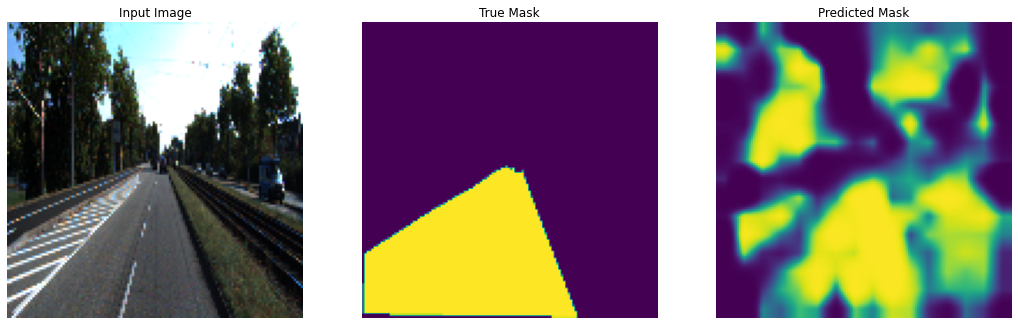

In [19]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

### Train Model

In [20]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]
        
# Set Variables
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE

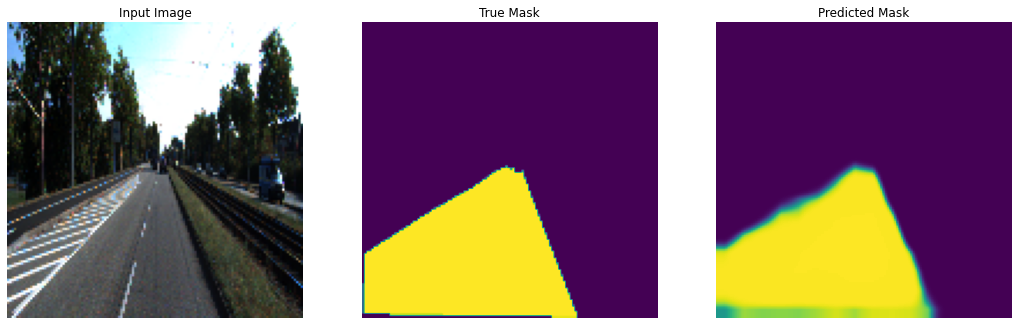


Sample Prediction after epoch 200



In [21]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

## Testing (Test Dataset)

In [22]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [23]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

Processing image : 0


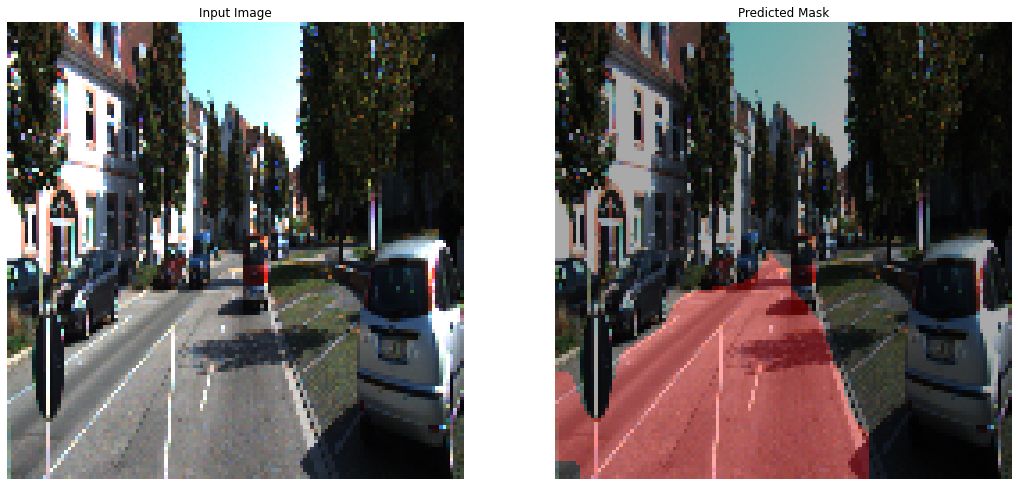

Processing image : 1


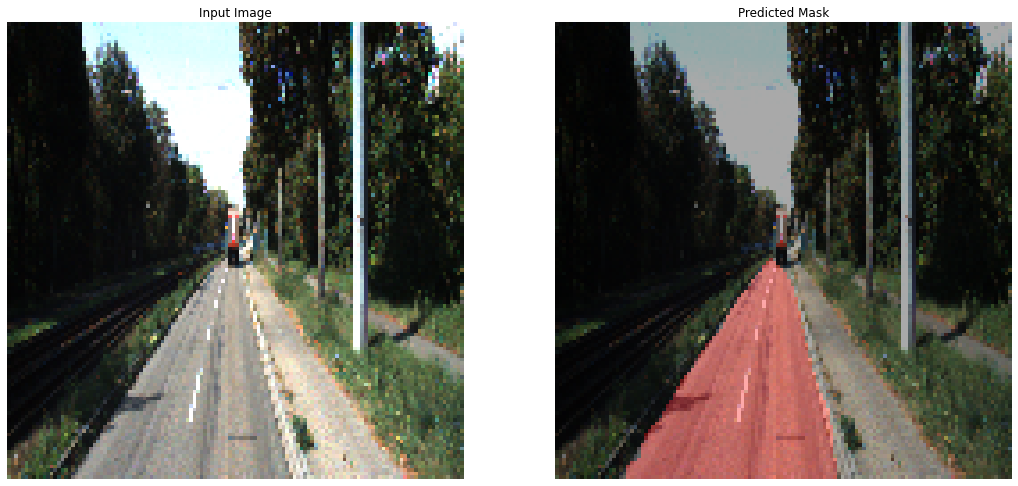

Processing image : 2


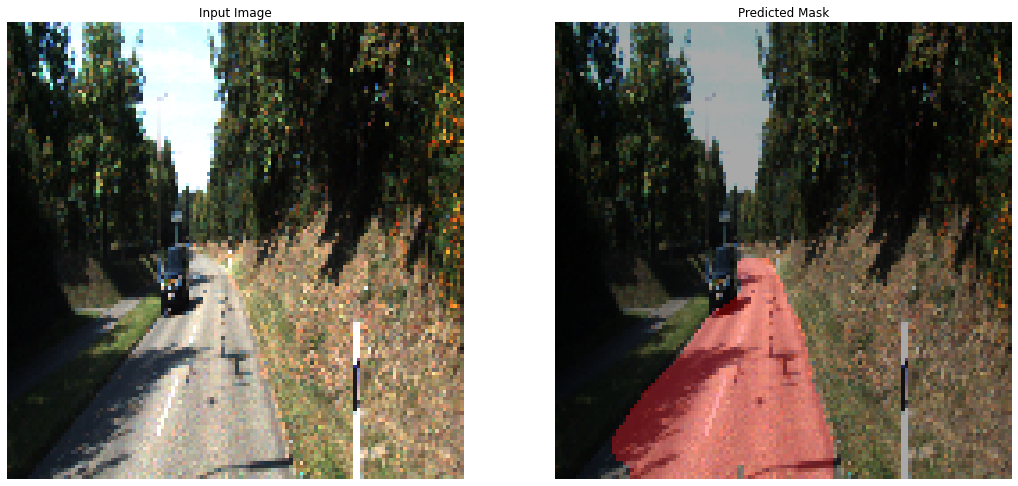

Processing image : 3


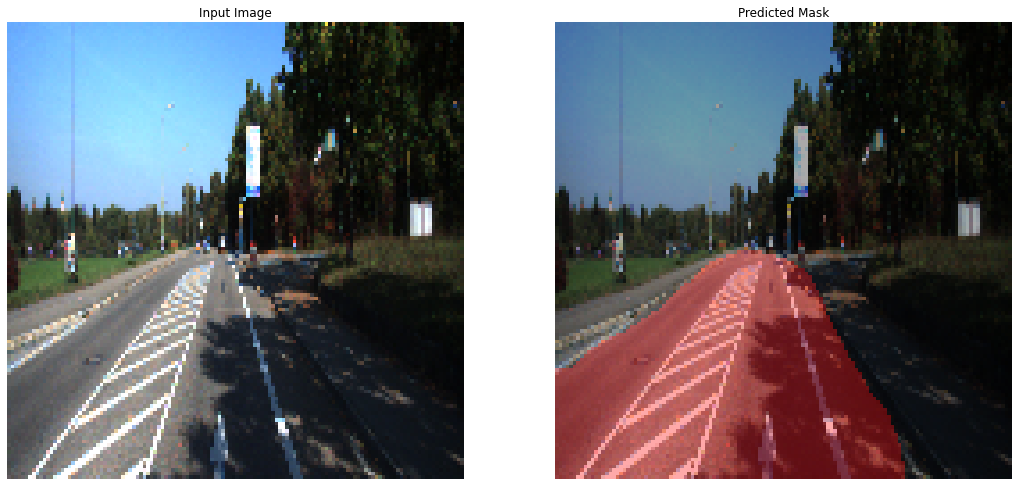

Processing image : 4


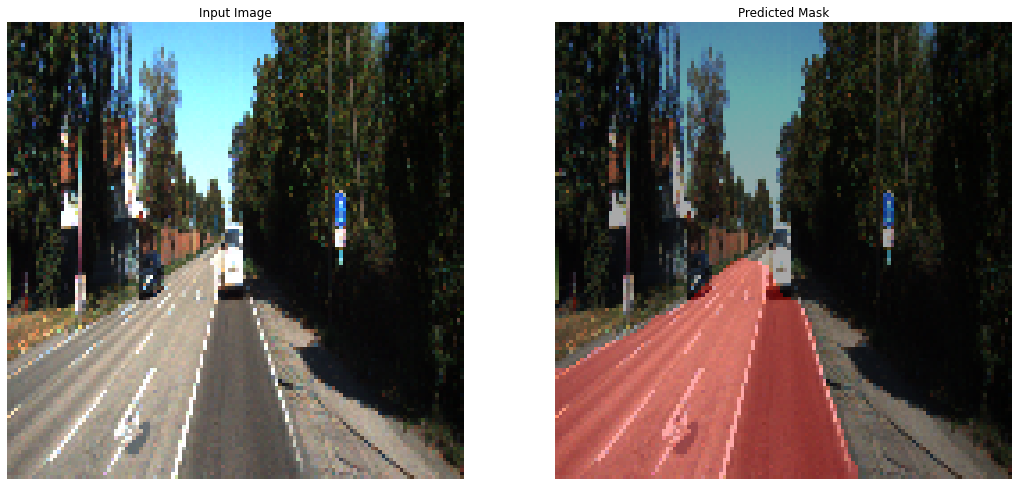

Processing image : 5


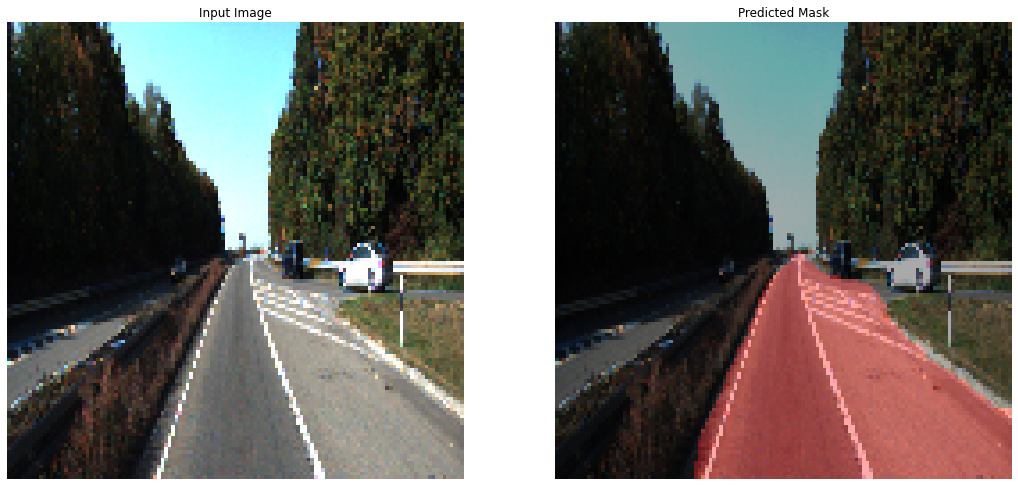

Processing image : 6


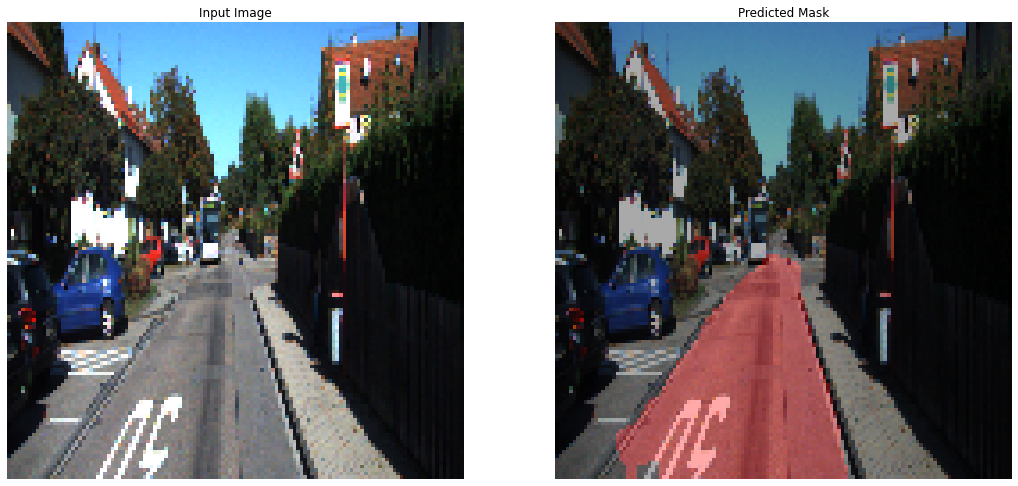

Processing image : 7


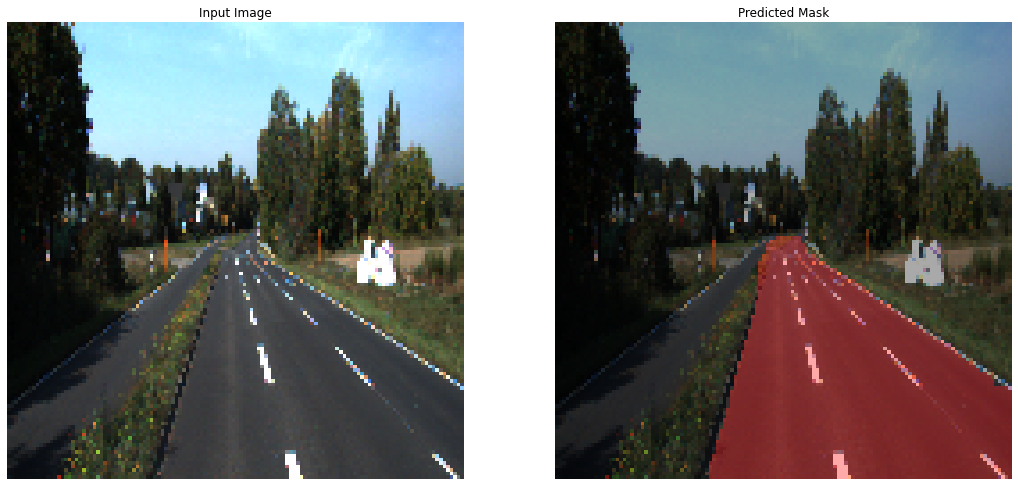

Processing image : 8


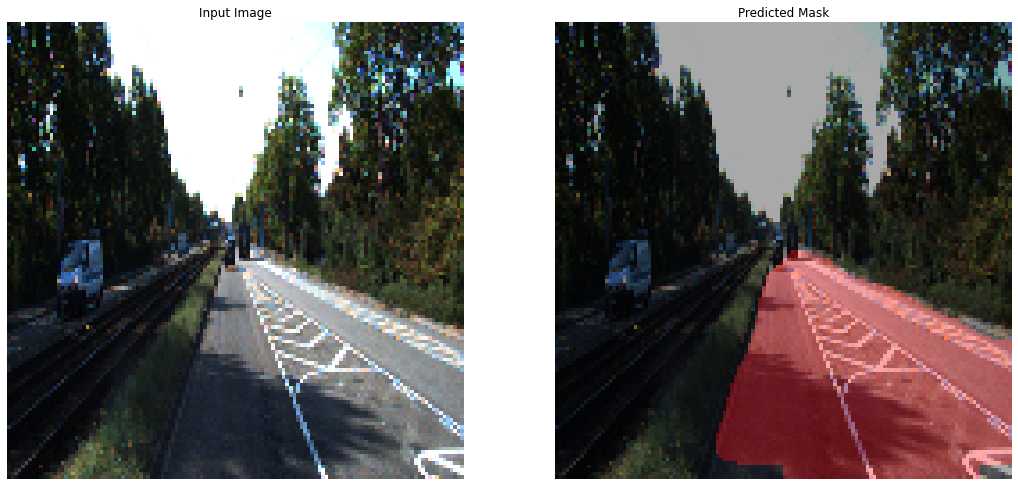

Processing image : 9


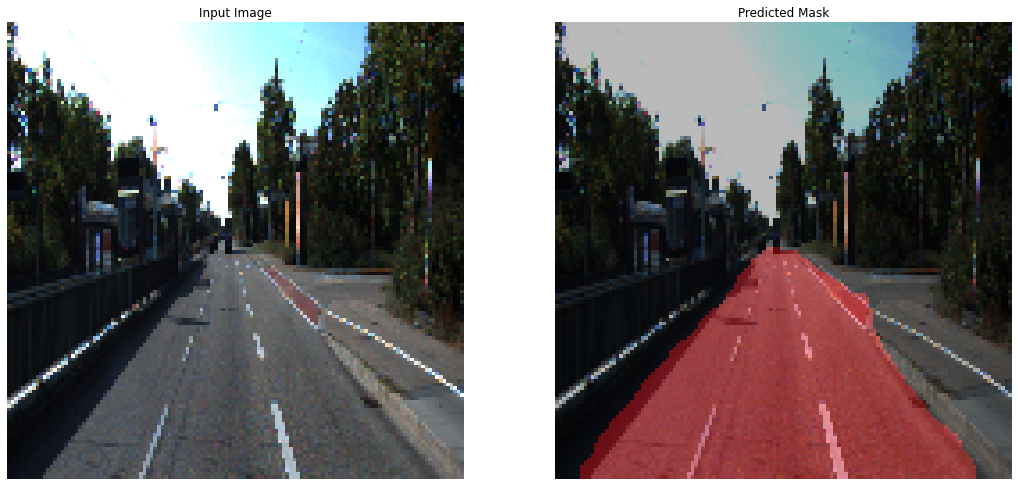

Processing image : 10


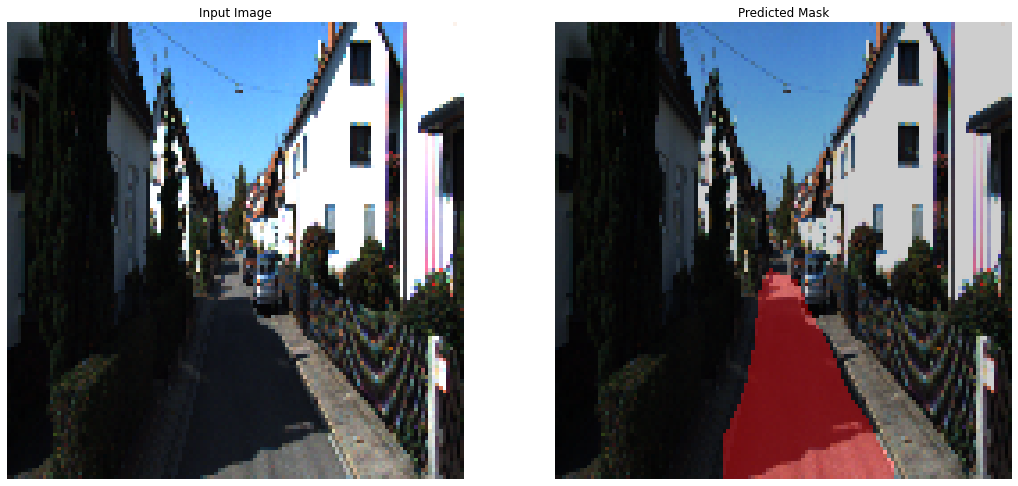

Processing image : 11


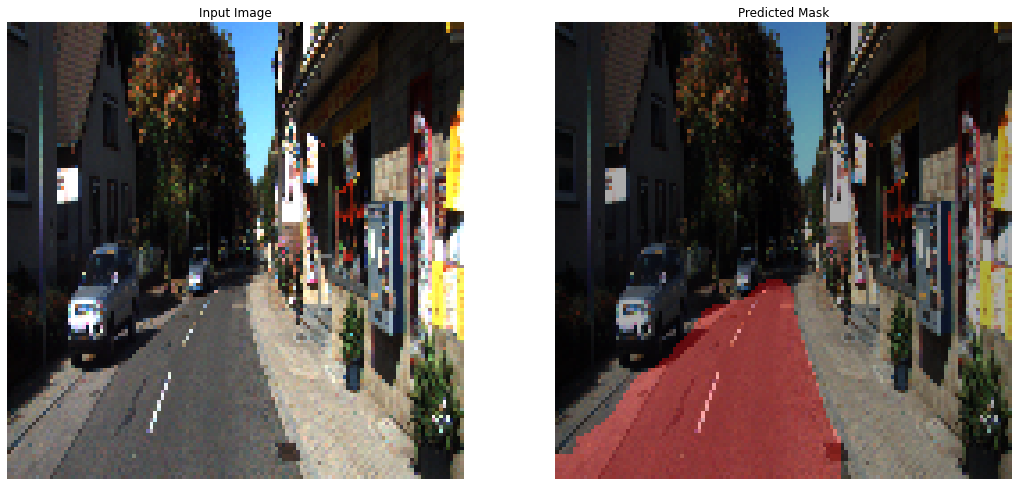

Processing image : 12


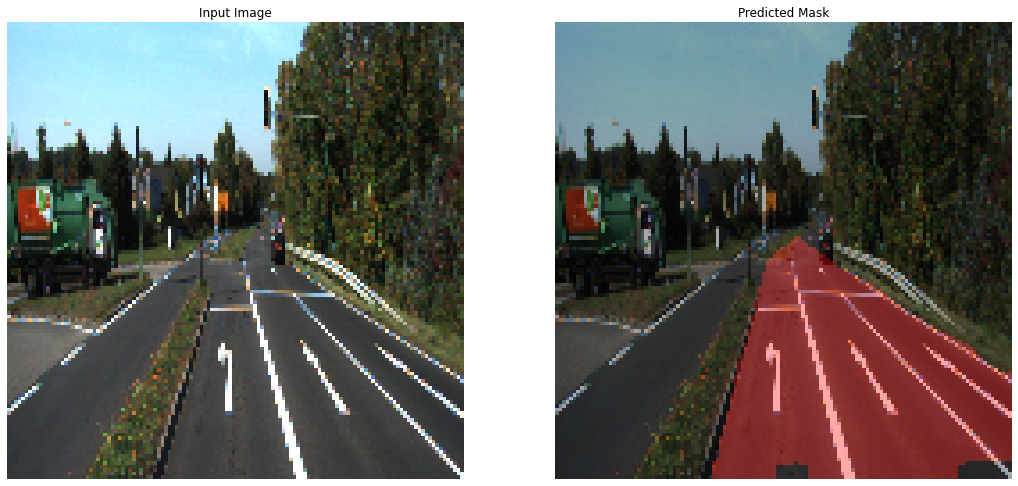

Processing image : 13


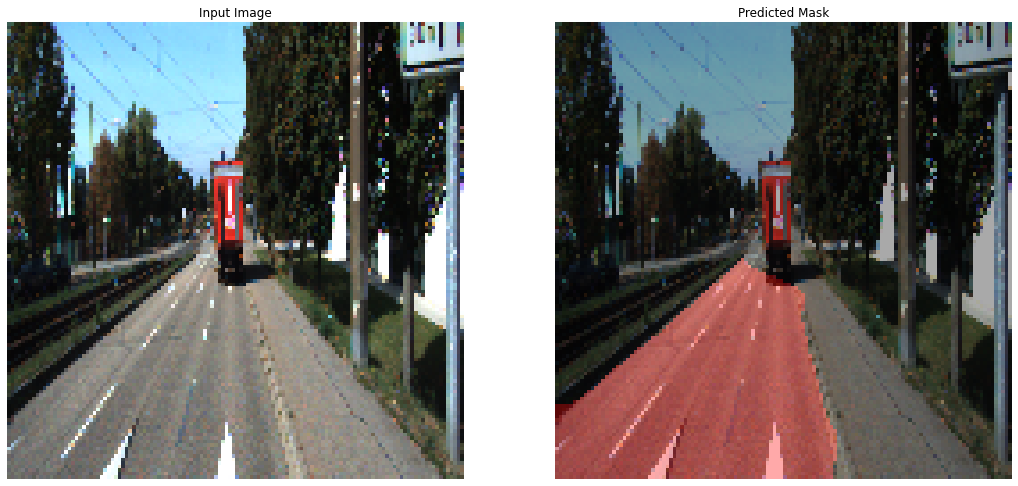

Processing image : 14


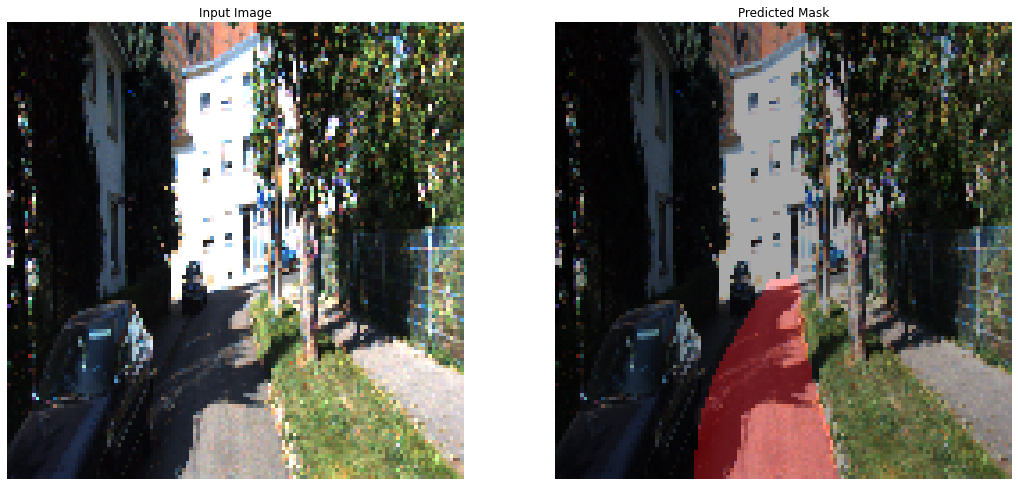

Processing image : 15


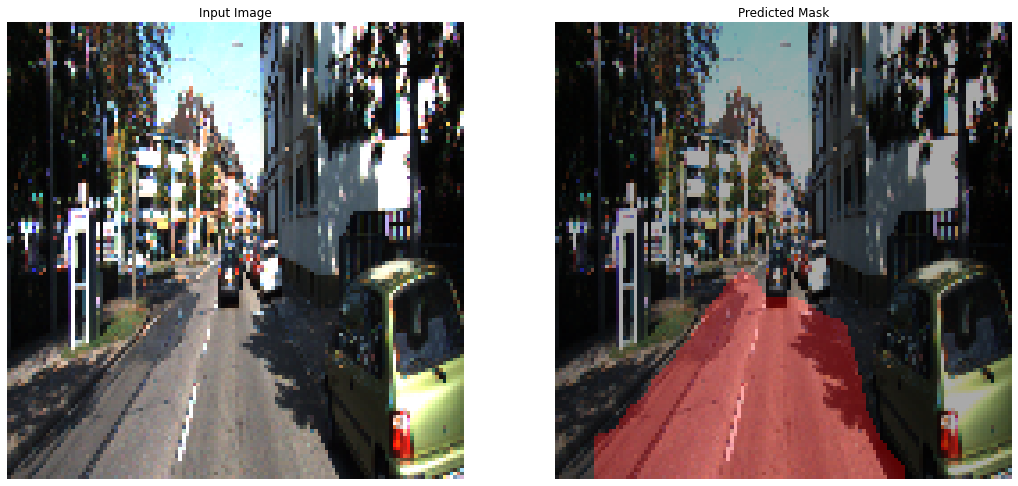

Processing image : 16


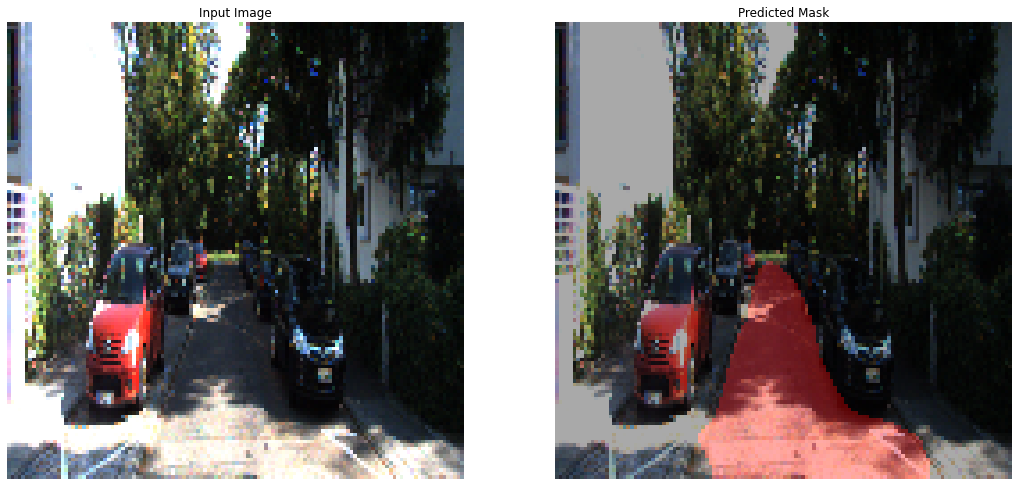

Processing image : 17


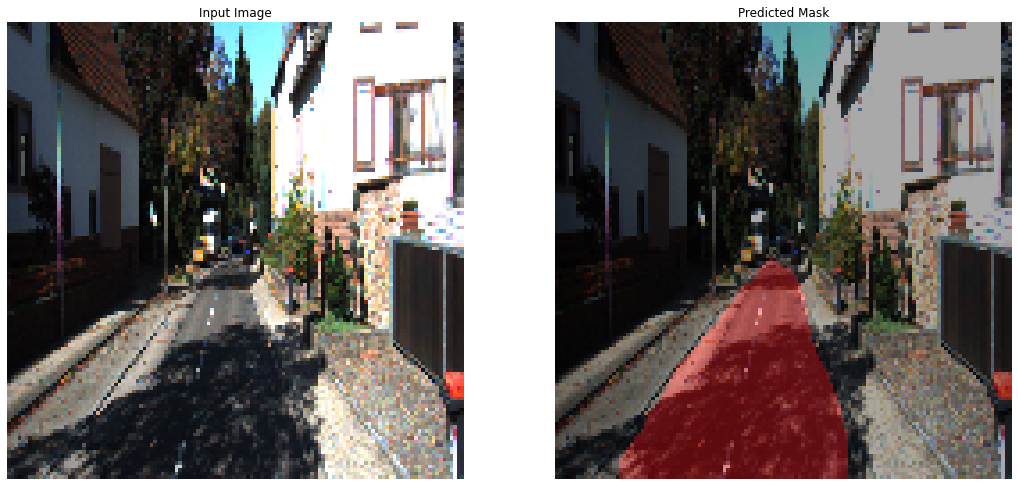

Processing image : 18


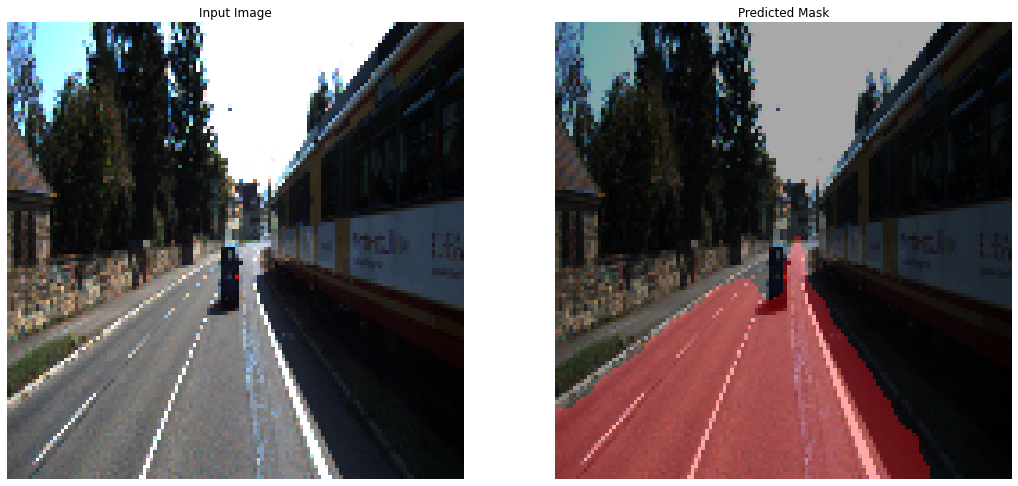

Processing image : 19


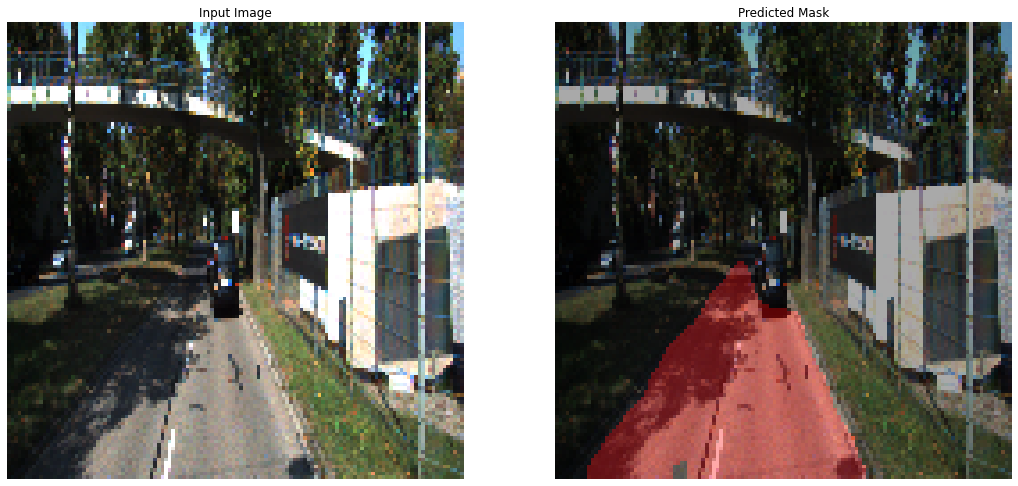

Processing image : 20


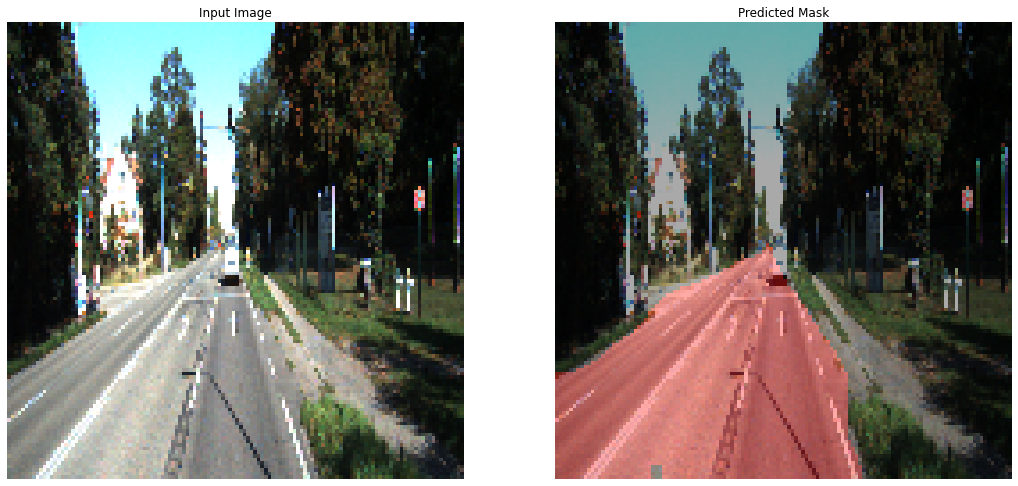

Processing image : 21


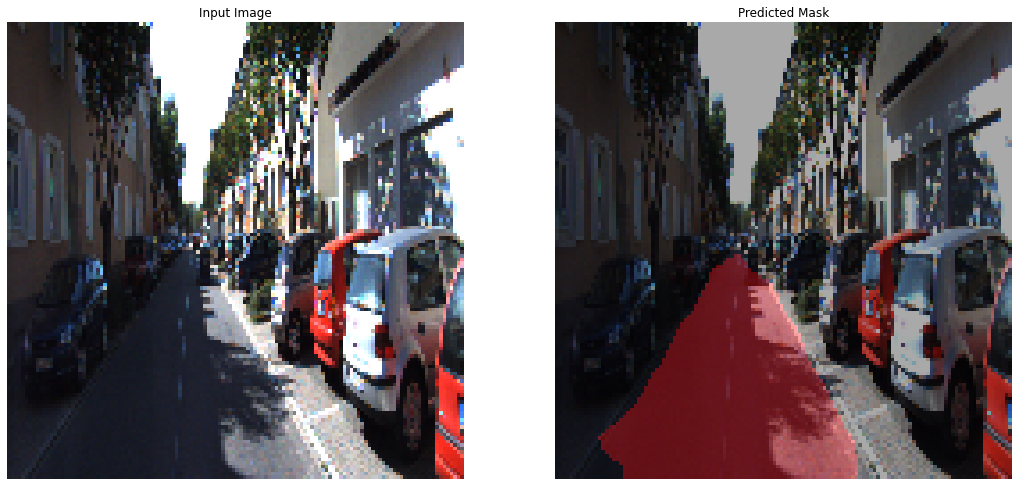

Processing image : 22


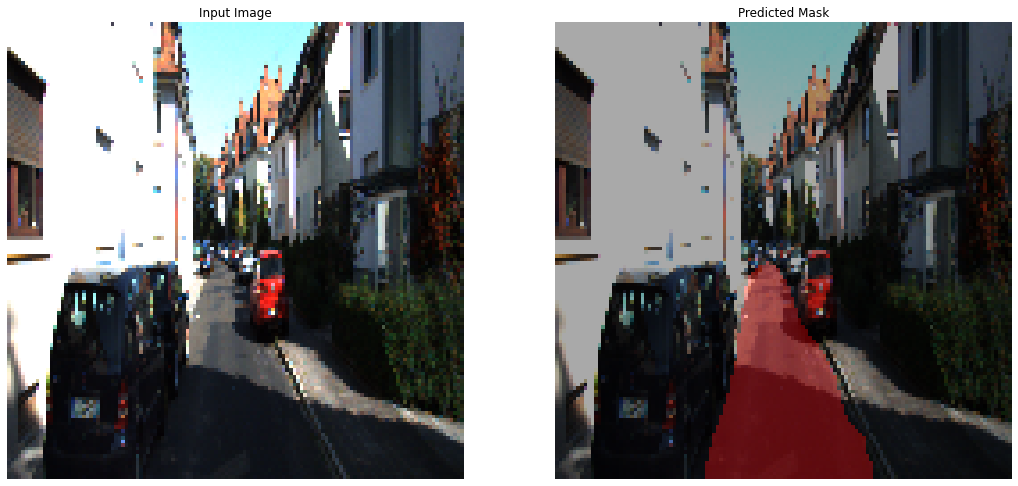

Processing image : 23


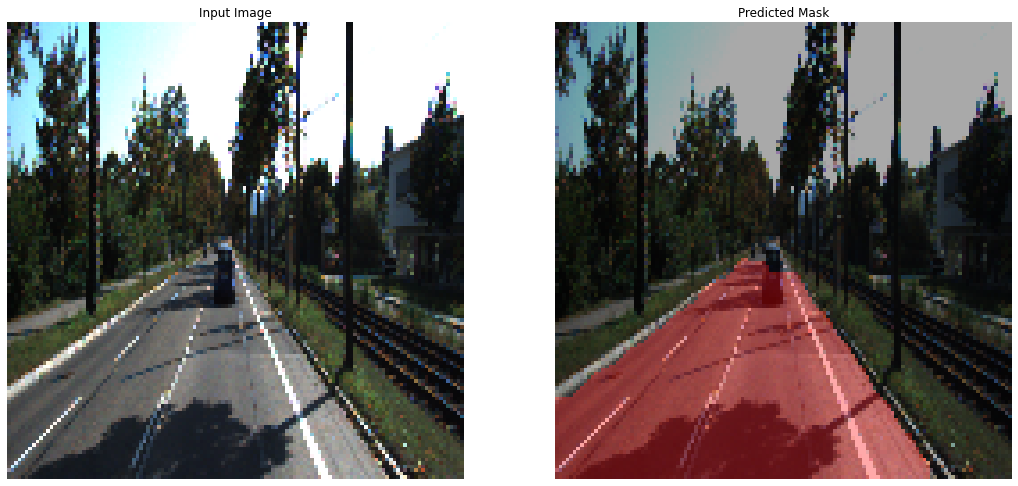

Processing image : 24


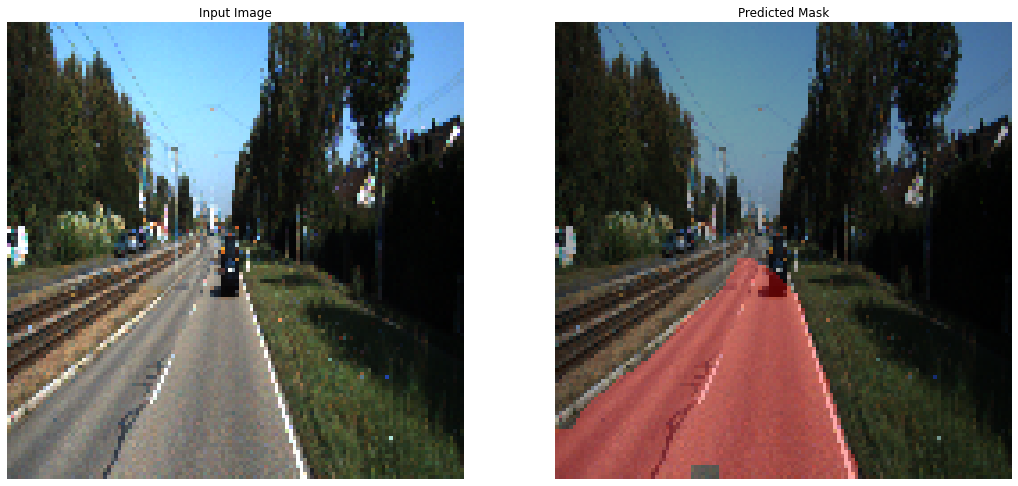

Processing image : 25


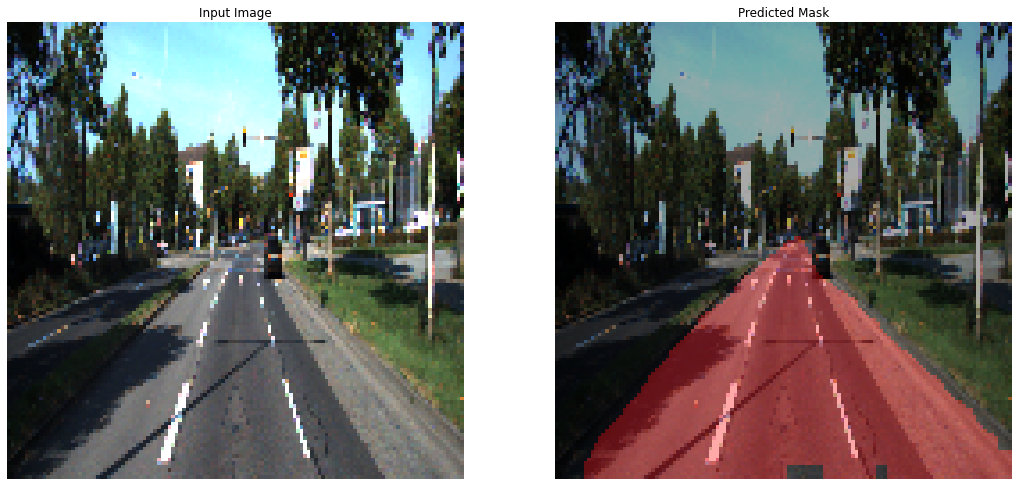

Processing image : 26


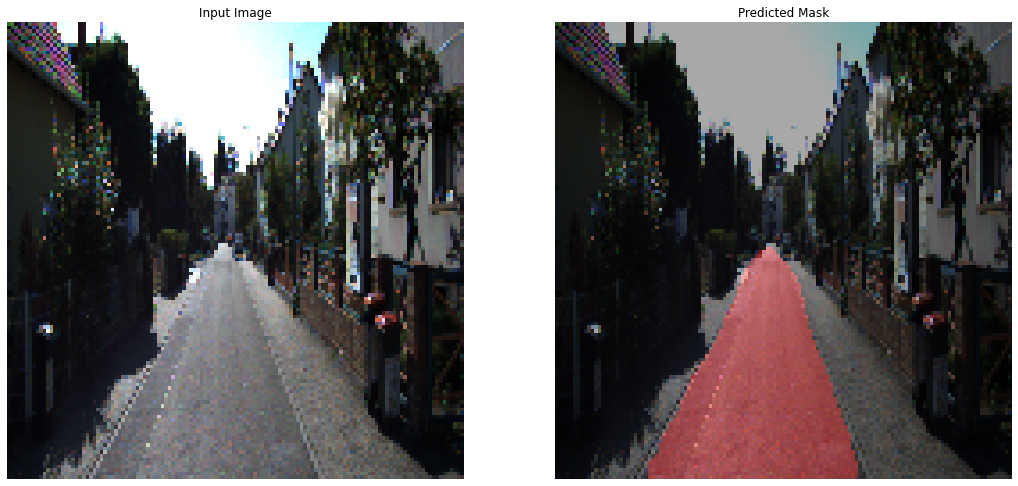

Processing image : 27


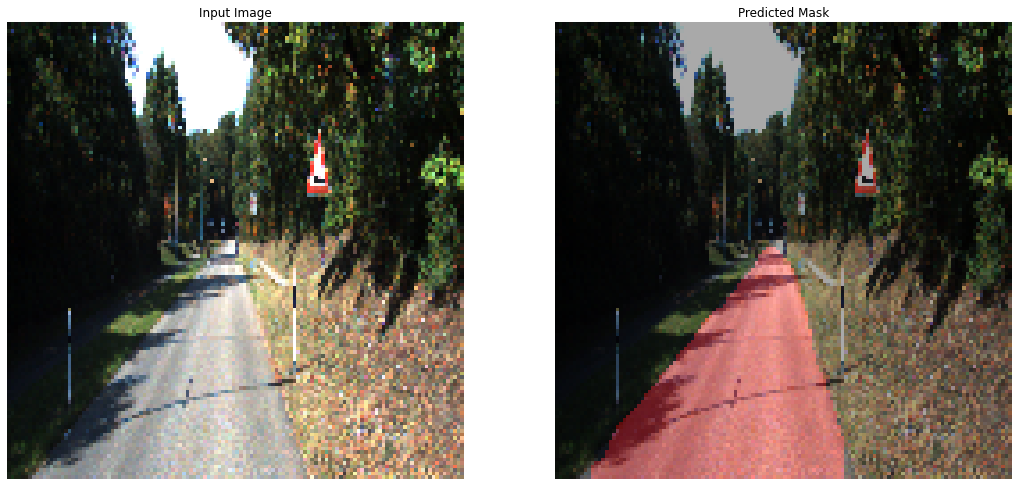

Processing image : 28


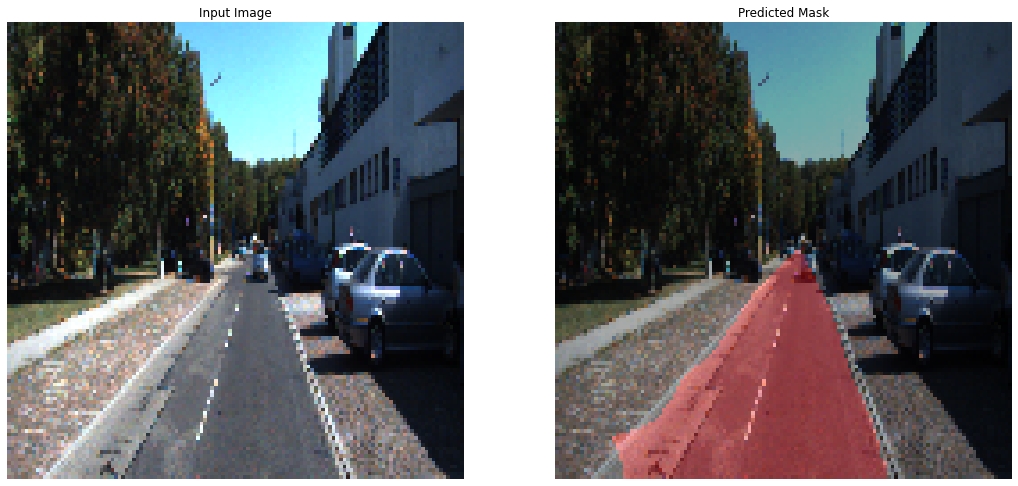

Processing image : 29


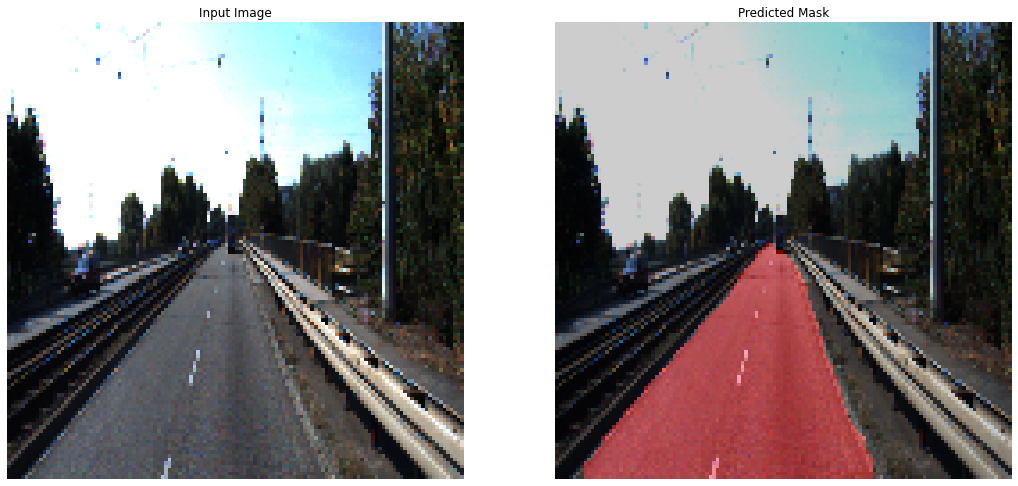

In [24]:
os.mkdir("outputs")
save_predictions(dataset['test'])

## Testing (Videos)

In [ ]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)
    
    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Make a new directory
os.mkdir("videos")

### Project Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "project_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Challenge Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Challenge Video 2

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

### Harder Challenge Video

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "harder_challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

## References

- [Kitti Dataset Processing](http://ronny.rest/blog/post_2017_09_06_kitti_road_data/)
- [Image Segmentation on Keras](https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/)